<a href="https://colab.research.google.com/github/yzhang45/Deep-Learning-CNN-based-Car-Classification/blob/master/%E2%80%9Ccar_classification_proj1_ipynb%E2%80%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Note: Please "Copy" this notebook before you work on it !!!!
In File   ->   Save a copy in Drive

# 1.introduction

This project is about car classification for [stanford car dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html). The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.

It is difficult to directly train deep learning model on this dataset because the limited number of images. Thus we decide to use transfer learning, a common approch used in deep learning to utilize the pretrained model on [imagenet](http://www.image-net.org/) and fine-tune on our own dataset, i.e. car dataset.

This project can show you how to train and fine-tune a deep learning model using kera (tensorflow backend).

![](https://ai.stanford.edu/~jkrause/cars/class_montage.jpg)

## 1.1 Transfer Learning
Transfer learning is one of the most widely used technologies in deep learning and computer vision. If you are not familar with the concept of transfer learning, please refer to our course materials.

![](https://cdn-images-1.medium.com/max/2000/1*9GTEzcO8KxxrfutmtsPs3Q.png)

# 2.Making a car classifier using Pytorch

In this notebook I'm making a car classifier using the Stanford car dataset, which contains 196 classes.
I'll be using a pre-trained model with transfer learning to train the model. All layers will be fine tuned and the last fully connected layer will be replaced entirely.

Dataset (196 classes):

Train folder: 8144 images, avg: 41.5 images per class.

Test folder: 8041 images, avg: 41.0 images per class.

## 2.1 mount google drive to colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## 2.2 Copy file from google drive to colab

In [ ]:
# copy dataset from google drive to colab. https://drive.google.com/open?id=1qcSFJ_2Ouom95QYDI3n498JEnqQd71vx
!cp ./drive/My\ Drive/stanford_car_dataset.zip ./

## 2.3 Extract dataset files

In [ ]:
%%time
# unzip dataset in colab
!mkdir ./stanford_car_dataset
!unzip -q stanford_car_dataset.zip -d ./stanford_car_dataset

CPU times: user 100 ms, sys: 21.7 ms, total: 122 ms
Wall time: 51.6 s


# 3.Build model

## 3.1 Load packages

The pytorch have been pre-installled on colab, and we do not need re-install these packages.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import time
import os
import tqdm
import PIL.Image as Image
from IPython.display import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla T4


## 3.2 Load the data and transform

First, lets create some transforms for our data and load the train/test data+labels from the folders.

Here we are using 224x224 images (you can also change the resolution) with random horizontal flip, random rotation and normalization

In [ ]:
dataset_dir = "stanford_car_dataset/car_data/car_data/"

# data transformation, you can try different transformation/ data augmentation here
# note: no data augmentation for test data

width, height = 224, 224
train_tfms = transforms.Compose([transforms.Resize((width, height)),
                                 # transforms.RandomHorizontalFlip(),
                                 # transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_tfms = transforms.Compose([transforms.Resize((width, height)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# create datasets
dataset = torchvision.datasets.ImageFolder(root=dataset_dir + "train", transform=train_tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir+"test", transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size=32, shuffle=False, num_workers=2)


## 3.3 Model training function

Here we train our model, after each epoch, we test the model on the test data to see how it's going

In [ ]:
def train_model(model, criterion, optimizer, scheduler, n_epochs=5):
    
    losses = []
    accuracies = []
    test_accuracies = []

    # set the model to train mode initially
    model.train()
    for epoch in tqdm.tqdm(range(n_epochs)):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            #inputs = inputs.to(device).half() # uncomment for half precision model
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time() - since
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 / 32 * running_correct / len(trainloader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

## 3.4 Evaluate on training data
This function is called out after each epoch of training on the training data. We then measure the accuracy of the model.

In [ ]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            #images = images.to(device).half() # uncomment for half precision model
            images = images.to(device)
            labels = labels.to(device)

            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

# 4.Experiment

## 4.1 define parameters

In [ ]:
NUM_CAR_CLASSES = 196
#model_ft = models.alexnet(pretrained=True)  # resnet34(pretrained=True)
model_ft = models.resnet34(pretrained=True)


# Freezing model parameters and defining the fully connected network to be attached to the model, 
# loss function and the optimizer.
# We there after put the model on the GPUs
# for param in model_ft.parameters():
#     param.require_grad = False

# replace the last fc layer with an untrained one (requires grad by default)

# for alexnet
# num_ftrs = model_ft.classifier[6].in_features
# model_ft.classifier[6] = nn.Linear(num_ftrs, NUM_CAR_CLASSES)

# for resnet34
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, NUM_CAR_CLASSES)

model_ft = model_ft.to(device)

# uncomment this block for half precision model
"""
model_ft = model_ft.half()


for layer in model_ft.modules():
    if isinstance(layer, nn.BatchNorm2d):
        layer.float()
"""
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

"""
probably not the best metric to track, but we are tracking the training accuracy and measuring whether
it increases by atleast 0.9 per epoch and if it hasn't increased by 0.9 reduce the lr by 0.1x.
However in this model it did not benefit me.
"""
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


## 4.2 model training

In [ ]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, duration: 87 s, loss: 3.6374, acc: 20.0735


  5%|▌         | 1/20 [02:43<51:49, 163.66s/it]

Accuracy of the network on the test images: 30 %
Epoch 2, duration: 84 s, loss: 1.4656, acc: 59.4608


 10%|█         | 2/20 [05:22<48:42, 162.34s/it]

Accuracy of the network on the test images: 50 %
Epoch 3, duration: 84 s, loss: 0.6770, acc: 80.3922


 15%|█▌        | 3/20 [08:01<45:39, 161.16s/it]

Accuracy of the network on the test images: 61 %
Epoch 4, duration: 83 s, loss: 0.3010, acc: 91.2010


 20%|██        | 4/20 [10:39<42:44, 160.30s/it]

Accuracy of the network on the test images: 66 %
Epoch 5, duration: 84 s, loss: 0.1251, acc: 96.8627


 25%|██▌       | 5/20 [13:18<39:56, 159.77s/it]

Accuracy of the network on the test images: 71 %
Epoch 6, duration: 84 s, loss: 0.0484, acc: 98.8480


 30%|███       | 6/20 [15:57<37:13, 159.54s/it]

Accuracy of the network on the test images: 78 %
Epoch 7, duration: 84 s, loss: 0.0213, acc: 99.4853


 35%|███▌      | 7/20 [18:35<34:29, 159.22s/it]

Accuracy of the network on the test images: 81 %
Epoch 8, duration: 84 s, loss: 0.0123, acc: 99.6078


 40%|████      | 8/20 [21:14<31:48, 159.04s/it]

Accuracy of the network on the test images: 82 %
Epoch 9, duration: 83 s, loss: 0.0095, acc: 99.6569


 45%|████▌     | 9/20 [23:52<29:06, 158.79s/it]

Accuracy of the network on the test images: 82 %
Epoch 10, duration: 84 s, loss: 0.0090, acc: 99.6446


 50%|█████     | 10/20 [26:31<26:27, 158.77s/it]

Accuracy of the network on the test images: 82 %
Epoch 11, duration: 83 s, loss: 0.0083, acc: 99.6569


 55%|█████▌    | 11/20 [29:09<23:46, 158.54s/it]

Accuracy of the network on the test images: 82 %
Epoch 12, duration: 84 s, loss: 0.0078, acc: 99.6569


 60%|██████    | 12/20 [31:47<21:07, 158.47s/it]

Accuracy of the network on the test images: 82 %
Epoch 13, duration: 84 s, loss: 0.0076, acc: 99.6814


 65%|██████▌   | 13/20 [34:26<18:29, 158.50s/it]

Accuracy of the network on the test images: 82 %
Epoch 14, duration: 83 s, loss: 0.0077, acc: 99.6814


 70%|███████   | 14/20 [37:04<15:50, 158.49s/it]

Accuracy of the network on the test images: 82 %
Epoch 15, duration: 83 s, loss: 0.0077, acc: 99.6324


 75%|███████▌  | 15/20 [39:42<13:12, 158.42s/it]

Accuracy of the network on the test images: 82 %
Epoch 16, duration: 84 s, loss: 0.0077, acc: 99.6324


 80%|████████  | 16/20 [42:22<10:34, 158.68s/it]

Accuracy of the network on the test images: 82 %
Epoch 17, duration: 84 s, loss: 0.0074, acc: 99.6324


 85%|████████▌ | 17/20 [45:00<07:55, 158.65s/it]

Accuracy of the network on the test images: 82 %
Epoch 18, duration: 84 s, loss: 0.0079, acc: 99.6691


 90%|█████████ | 18/20 [47:39<05:17, 158.62s/it]

Accuracy of the network on the test images: 82 %
Epoch 19, duration: 84 s, loss: 0.0076, acc: 99.7059


 95%|█████████▌| 19/20 [50:17<02:38, 158.58s/it]

Accuracy of the network on the test images: 82 %
Epoch 20, duration: 83 s, loss: 0.0074, acc: 99.6569


100%|██████████| 20/20 [52:55<00:00, 158.79s/it]

Accuracy of the network on the test images: 82 %
Finished Training


## 4.3 As we can see the model reached 90% training accuracy by epoch 10.


Text(0.5, 1.0, 'Test acc')

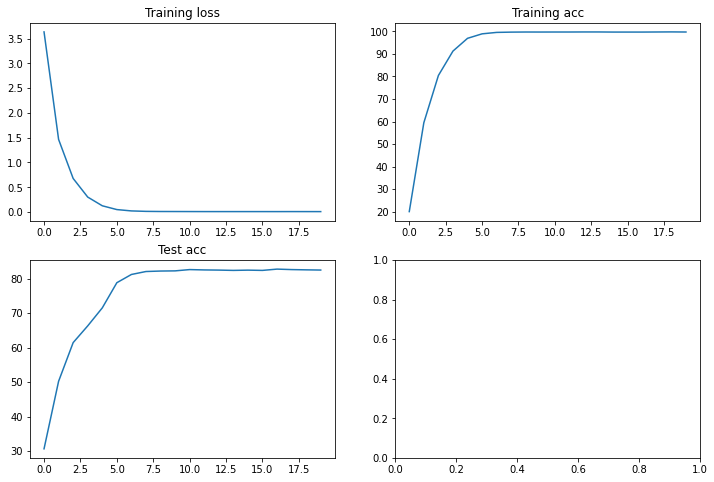

In [ ]:
# plot the stats

f, axarr = plt.subplots(2,2, figsize = (12, 8))
axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(training_accs)
axarr[0, 1].set_title("Training acc")
axarr[1, 0].plot(test_accs)

axarr[1, 0].set_title("Test acc")

## 4.4 Evaluate the model on single images (e.g for production)

Next we can use the model on our own images. For that we need to tie the class numbers for which the model returns probablities with the names of those classes.


In [ ]:
# tie the class indices to their names

def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(dataset_dir+"train")

In [ ]:
# test the model on random images


# switch the model to evaluation mode to make dropout and batch norm work in eval mode
model_ft.eval()

# transforms for the input image
loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
image = Image.open(dataset_dir+"test/Mercedes-Benz C-Class Sedan 2012/01977.jpg")
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
image = image.cuda()
output = model_ft(image)
conf, predicted = torch.max(output.data, 1)

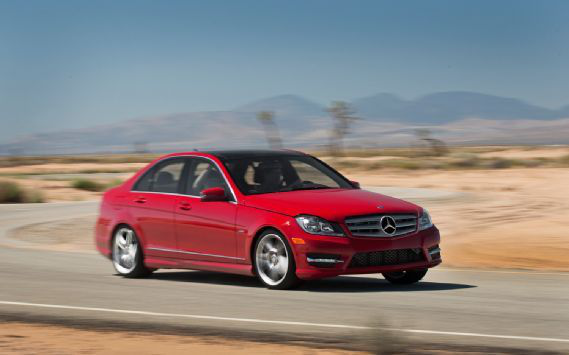

Mercedes-Benz C-Class Sedan 2012 confidence:  6.419861316680908


In [ ]:
# get the class name of the prediction
display(Image.open(dataset_dir+"test/Mercedes-Benz C-Class Sedan 2012/01977.jpg"))
print(classes[predicted.item()], "confidence: ", conf.item())

# 5.Save and load model

In [ ]:
PATH = 'car_model.pth'
torch.save(model_ft.state_dict(), PATH)

In [ ]:
model_loaded = torch.load(PATH)
model_loaded


OrderedDict([('conv1.weight',
              tensor([[[[ 9.1898e-03, -6.4284e-03,  8.1509e-05,  ...,  4.3689e-02,
                          3.9652e-02,  3.9848e-02],
                        [ 4.6565e-02,  3.4449e-02,  3.5864e-02,  ...,  3.3231e-02,
                          4.4869e-02,  6.4670e-02],
                        [ 1.4162e-02, -2.8982e-02, -6.1888e-02,  ..., -1.1240e-01,
                         -1.1906e-01, -1.1737e-01],
                        ...,
                        [-1.6795e-02, -2.7811e-02, -6.3148e-03,  ...,  1.3470e-02,
                         -4.9071e-03,  1.0793e-02],
                        [ 3.7246e-03,  1.2691e-02,  4.8486e-02,  ...,  1.0607e-01,
                          7.6348e-02,  6.0881e-02],
                        [ 1.6912e-02,  1.8443e-02,  4.6774e-02,  ...,  9.6358e-02,
                          8.8436e-02,  9.3200e-02]],
              
                       [[-5.6405e-03, -1.1201e-02,  6.6388e-03,  ...,  3.1025e-02,
                          3.3271